In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import re
import datetime
import seaborn as sns
import pickle
import gzip
import matplotlib.pyplot as plt

The aim of this notebook is to identify the channels that talk about a release event to analyse their evolution in terms of the number of subscribers compared to those which do not talk about the event . First, we focus on 1 event. Then, we will generalize to the 5 others. From the title and tags of the videos, we classify them according to the presence of the "item" in this metadata - treat (if talks about the relelase - control if not). We focus on videos that have an upload date from the release till one month after.
Then, we classify the channels considering that if a channel has at least one video that talk about the release, it is treat channel. 
We compare the growth of channels (measured with the number of views) for treat and control channels to see if channels that talks about a release have a higher growth than he ones which do not. To do this comparaison, we use the time series data and focus on a period that goes from one month before the release till one month after.
Then, we do an observational study (causal analysis) with the outcome being the number of subscribers while identifying the counfounders.
We first, focus on 1 event "iphone x"

1. classify channels in the treat control group,
2. causal observation (like lab 5) and outcome nb of subscribers one month after the event 

In [2]:
tech_video_metadata = "/Users/salma/Desktop/ADA/project/datasets/tech_review_videos.tsv.gz"
tech_channels_metadata = "/Users/salma/Desktop/ADA/project/datasets/tech_review_channels.tsv.gz"

In [3]:
ITEMS = ['iphone x', 'iphone 7', 'iphone 6', 'galaxy s9', 'galaxy note 9', 'galaxy fold']
RELEASE_DATES = {'iphone x': '2017-11-03','iphone 7': '2016-09-16','iphone 6': '2014-09-19',
    'galaxy s9': '2018-03-16',
   'galaxy note 9': '2018-08-24',
    'galaxy fold': '2019-02-01'
}


In [4]:
df_video = pd.read_table(tech_video_metadata)
df_channel = pd.read_table(tech_channels_metadata)

In [5]:
df_video


,channel_id,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,num_comms,clean_title,clean_tags
0,UCzWQYUVCpZqtN93H8RR44Qw,87.0,ExOXF1x3N1g,292,7386.0,"current events,Science,biofuel,algae,power,Bio...",We Can Power The World With Algae!,2016-09-29,235974.0,700.0,"['power', 'world', 'algae']","['current', 'event', 'science', 'biofuel', 'al..."
1,UCzWQYUVCpZqtN93H8RR44Qw,36.0,_RhHuW2gglw,193,1933.0,"Energy (Dimension),testtube,fertilizer,human w...",How Poop Will Power The World,2013-09-15,92531.0,465.0,"['poop', 'power', 'world']","['energy', 'dimension', 'testtube', 'fertilize..."
2,UCzWQYUVCpZqtN93H8RR44Qw,34.0,g513EUHqkfw,191,2556.0,"social,networking,first impressions,judge,meet...",How First Impressions Work,2012-12-10,164020.0,248.0,"['first', 'impression', 'work']","['social', 'networking', 'first', 'impression'..."
3,UCzVy1DW9NFp4c910hMd_jIw,1.0,fRY3dpFBF14,217,72.0,"Sony,8K,Sony 8K,TV,2019 Sony 8K,8K Television,...",Sony 8K Z9G Master Series Smart TV,2019-08-23,2585.0,12.0,"['sony', 'master', 'series', 'smart', 'tv']","['sony', 'sony', 'tv', 'sony', 'television', '..."
4,UCzVy1DW9NFp4c910hMd_jIw,3.0,VenwYvLRa-I,437,107.0,"Bowers and Wilkins,B&W,Bowers,Wilkins,603,606,...",Bowers & Wilkins 600 Series Speaker Comparison,2019-08-13,5974.0,19.0,"['bower', 'wilkins', 'series', 'speaker', 'com...","['bower', 'wilkins', 'bower', 'wilkins', 'cent..."
...,...,...,...,...,...,...,...,...,...,...,...,...
178250,UCrwT2LIOntbglCR2o0iOXVw,20.0,WjcXvzzRB0M,196,486.0,"surface book,best laptop for engineering,elect...",The Best Engineering Laptop!Mac or PC?,2018-07-08,42628.0,79.0,"['best', 'engineering', 'laptop', 'mac', 'pc']","['surface', 'book', 'best', 'laptop', 'enginee..."
178251,UCrwPkTBuhZJDgiHkWzY7COw,35.0,UySYfgQaIlo,200,31.0,"how to install windows 10 on android phone,win...",How to Install Windows 10 on Any Android Phone...,2018-10-20,2723.0,7.0,"['install', 'window', 'android', 'phone']","['install', 'window', 'android', 'phone', 'win..."
178252,UCrwPkTBuhZJDgiHkWzY7COw,0.0,lqpuuKkh-lA,226,11.0,"Best Video player for Android,video player,vid...",Best Video Player For Android Phone - Must Try!,2018-06-19,897.0,0.0,"['best', 'video', 'player', 'android', 'phone'...","['best', 'video', 'player', 'android', 'video'..."
178253,UCrwMvZOgSvS2srsIjY-iIGg,0.0,7uFD7TYwlW4,182,7.0,NaN,I PHONE 11MAX PRO REVIEW,2019-09-21,54.0,0.0,"['phone', 'max', 'pro', 'review']",[]


In [6]:
df_channel

,join_date,channel_id,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,count_tech_videos
0,2010-12-21,UCsTcErHg8oDvUnTzoqsYeNw,Unbox Therapy,15300000,1672,206.0,2.0870,406.0
1,2015-10-19,UCOhHO2ICt0ti9KAh-QHvttQ,Technical Guruji,13979890,2539,240.0,2.0870,209.0
2,2012-05-18,UCe_vXdMrHHseZ_esYUskSBw,CrazyRussianHacker,11200000,1411,444.0,2.0870,105.0
3,2005-06-22,UCE_M8A5yxnLfW0KghEeajjw,Apple,9970000,291,489.0,2.0870,64.0
4,2008-03-21,UCBJycsmduvYEL83R_U4JriQ,Marques Brownlee,9400000,1148,530.0,2.0870,370.0
...,...,...,...,...,...,...,...,...
1188,2012-06-06,UCgMHqEDFll6X962CgXPzh4w,FocusCamera TV,10000,278,940963.0,40.6530,42.0
1189,2018-02-25,UCJjacdkHH7Zxw8ouKQrirUg,The Best Coders,10200,28,941074.0,42.4845,2.0
1190,2016-07-17,UCviAcL8AlEoGqLDWx7t_iPw,Mobile Tag,10300,20,952387.0,53.1435,6.0
1191,2011-02-20,UCncAHfjOv1B_U8esTmLYukQ,Curtis Paradis,10300,97,963290.0,53.1435,11.0


In [7]:
df_video_cop = df_video.copy()
df_channel_cop = df_channel.copy()
# we merge the channels and video's metadata in a single dataframe
df_merged = df_video_cop.merge(df_channel_cop,on=['channel_id'],how ='left')
# we create a new column with the treat attribute being set to 1 if the video talks about the release, 0 otherwise
df_merged["treat"]= 0




In [8]:
#we transform all the titles and tags to lower case to look for the item's name
df_merged["tags"] = df_merged["tags"].str.lower()
df_merged["title"]= df_merged["title"].str.lower()
df_merged

,channel_id,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,num_comms,clean_title,clean_tags,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,count_tech_videos,treat
0,UCzWQYUVCpZqtN93H8RR44Qw,87.0,ExOXF1x3N1g,292,7386.0,"current events,science,biofuel,algae,power,bio...",we can power the world with algae!,2016-09-29,235974.0,700.0,"['power', 'world', 'algae']","['current', 'event', 'science', 'biofuel', 'al...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,UCzWQYUVCpZqtN93H8RR44Qw,36.0,_RhHuW2gglw,193,1933.0,"energy (dimension),testtube,fertilizer,human w...",how poop will power the world,2013-09-15,92531.0,465.0,"['poop', 'power', 'world']","['energy', 'dimension', 'testtube', 'fertilize...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,UCzWQYUVCpZqtN93H8RR44Qw,34.0,g513EUHqkfw,191,2556.0,"social,networking,first impressions,judge,meet...",how first impressions work,2012-12-10,164020.0,248.0,"['first', 'impression', 'work']","['social', 'networking', 'first', 'impression'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,UCzVy1DW9NFp4c910hMd_jIw,1.0,fRY3dpFBF14,217,72.0,"sony,8k,sony 8k,tv,2019 sony 8k,8k television,...",sony 8k z9g master series smart tv,2019-08-23,2585.0,12.0,"['sony', 'master', 'series', 'smart', 'tv']","['sony', 'sony', 'tv', 'sony', 'television', '...",2010-10-11,Audio Advice,19500.0,199.0,416394.0,8.1235,25.0,0
4,UCzVy1DW9NFp4c910hMd_jIw,3.0,VenwYvLRa-I,437,107.0,"bowers and wilkins,b&w,bowers,wilkins,603,606,...",bowers & wilkins 600 series speaker comparison,2019-08-13,5974.0,19.0,"['bower', 'wilkins', 'series', 'speaker', 'com...","['bower', 'wilkins', 'bower', 'wilkins', 'cent...",2010-10-11,Audio Advice,19500.0,199.0,416394.0,8.1235,25.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178250,UCrwT2LIOntbglCR2o0iOXVw,20.0,WjcXvzzRB0M,196,486.0,"surface book,best laptop for engineering,elect...",the best engineering laptop!mac or pc?,2018-07-08,42628.0,79.0,"['best', 'engineering', 'laptop', 'mac', 'pc']","['surface', 'book', 'best', 'laptop', 'enginee...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
178251,UCrwPkTBuhZJDgiHkWzY7COw,35.0,UySYfgQaIlo,200,31.0,"how to install windows 10 on android phone,win...",how to install windows 10 on any android phone...,2018-10-20,2723.0,7.0,"['install', 'window', 'android', 'phone']","['install', 'window', 'android', 'phone', 'win...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
178252,UCrwPkTBuhZJDgiHkWzY7COw,0.0,lqpuuKkh-lA,226,11.0,"best video player for android,video player,vid...",best video player for android phone - must try!,2018-06-19,897.0,0.0,"['best', 'video', 'player', 'android', 'phone'...","['best', 'video', 'player', 'android', 'video'...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
178253,UCrwMvZOgSvS2srsIjY-iIGg,0.0,7uFD7TYwlW4,182,7.0,NaN,i phone 11max pro review,2019-09-21,54.0,0.0,"['phone', 'max', 'pro', 'review']",[],NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [9]:
# we filter to focus on videos uploaded from the release date till 1 month after.
df_merged = df_merged.loc[(df_merged["upload_date"] > '2017-11-03')& (df_merged["upload_date"] <'2017-12-03')]



In [10]:
display(df_merged)

,channel_id,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,num_comms,clean_title,clean_tags,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,count_tech_videos,treat
33,UCzV07t6mx27AcEPmpAUJYXw,3.0,2g3ykHWEOsI,338,28.0,"rhino slider,rhino slider review,youtube video...",the best motion camera slider for youtube videos!,2017-11-28,805.0,3.0,"['best', 'motion', 'camera', 'slider', 'youtub...","['rhino', 'slider', 'rhino', 'slider', 'review...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
34,UCzV07t6mx27AcEPmpAUJYXw,86.0,HWMm3ERfFCs,324,142.0,"overhead camera,overhead camera mount,overhead...",the best overhead camera rig for youtube videos!,2017-11-26,21197.0,22.0,"['best', 'overhead', 'camera', 'rig', 'youtube...","['overhead', 'camera', 'overhead', 'camera', '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
35,UCzV07t6mx27AcEPmpAUJYXw,45.0,6xVfMLhsdRc,585,256.0,"google home mini,google home mini unboxing ind...",google home mini in india - unboxing & setup!,2017-11-19,15527.0,157.0,"['google', 'home', 'mini', 'india', 'unboxing'...","['google', 'home', 'mini', 'google', 'home', '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
36,UCzV07t6mx27AcEPmpAUJYXw,9.0,EWfSia7qNqI,139,24.0,"soumendra jena,sj,sj channel,soamjena,apple ip...",how to remove the top notch on apple iphone x!,2017-11-11,1247.0,7.0,"['remove', 'top', 'notch', 'apple', 'iphone']","['soumendra', 'jena', 'sj', 'sj', 'channel', '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
37,UCzV07t6mx27AcEPmpAUJYXw,3.0,lFD3YQgZC-o,478,63.0,"iphone x review,iphone 10 review,iphone x full...",apple iphone x - the detailed review!,2017-11-11,1300.0,63.0,"['apple', 'iphone', 'detailed', 'review']","['iphone', 'review', 'iphone', 'review', 'ipho...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
177760,UCsCex8aMDs2b39TS_49Mpcg,17.0,MZk2ctF6tpI,714,551.0,"lg v30 review,lg v30 vs note 8,lg v30 unboxing...",the best review of the most under rated phone ...,2017-12-02,18241.0,142.0,"['best', 'review', 'rated', 'phone']","['lg', 'review', 'lg', 'note', 'lg', 'unboxing...",2013-10-23,Jonathan Casey,74300.0,560.0,192469.0,5.741,165.0,0
177898,UCs7qwxT0HL2fLTtVrt4i45w,4.0,EgQUk0DBs_c,286,66.0,"how i plan out youtube videos,planning youtube...",how i plan out youtube videos,2017-11-24,1766.0,19.0,"['plan', 'youtube', 'video']","['plan', 'youtube', 'video', 'planning', 'yout...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
177966,UCs6KfncB4OV6Vug4o_bzijg,25.0,Y3HwTwYliwY,484,372.0,"protonvpn free,protonvpn review,protonvpn,prot...",protonvpn full complete review! the new best vpn?,2017-11-18,28321.0,98.0,"['protonvpn', 'full', 'complete', 'review', 'n...","['protonvpn', 'free', 'protonvpn', 'review', '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
177978,UCs11Yv5OnpY_b3Bff5ZJ9kw,564.0,PcgcD8HQb0M,383,19344.0,"iphone,iphonex,unboxing,apple,jordyn,jordyn jones",iphone x first impression/unboxing,2017-11-04,693417.0,0.0,"['iphone', 'first', 'impression', 'unboxing']","['iphone', 'iphonex', 'unboxing', 'apple', 'jo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [11]:
# look for the item's name in the title 
df_merged.loc[df_merged["title"].str.contains("iphone x"),"treat"] = '1' #example of display_id of video that talks about iphone x : lFD3YQgZC-o


In [12]:
# look for the item's name in the tags. Here, we need to pay attention to the missing values and 
df_merged.loc[df_merged["tags"].str.contains("iphone x",na=False),"treat"] = '1' 


In [13]:
display(df_merged.loc[df_merged['treat'] == '1'])

,channel_id,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count,num_comms,clean_title,clean_tags,join_date,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,count_tech_videos,treat
36,UCzV07t6mx27AcEPmpAUJYXw,9.0,EWfSia7qNqI,139,24.0,"soumendra jena,sj,sj channel,soamjena,apple ip...",how to remove the top notch on apple iphone x!,2017-11-11,1247.0,7.0,"['remove', 'top', 'notch', 'apple', 'iphone']","['soumendra', 'jena', 'sj', 'sj', 'channel', '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
37,UCzV07t6mx27AcEPmpAUJYXw,3.0,lFD3YQgZC-o,478,63.0,"iphone x review,iphone 10 review,iphone x full...",apple iphone x - the detailed review!,2017-11-11,1300.0,63.0,"['apple', 'iphone', 'detailed', 'review']","['iphone', 'review', 'iphone', 'review', 'ipho...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
38,UCzV07t6mx27AcEPmpAUJYXw,2.0,O4AoiYxgEek,139,13.0,"soumendra jena,sj,sj channel,soamjena,iphone x...",camera comparison : apple iphone x vs samsung s8+,2017-11-09,338.0,7.0,"['camera', 'comparison', 'apple', 'iphone', 's...","['soumendra', 'jena', 'sj', 'sj', 'channel', '...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
271,UCzLaQ6eeTVuAltzTrN7fzyg,49.0,j8N0_hpIbOg,371,164.0,"youtube tech guy,the android guy,cellphone,sma...",samsung gear fit 2 pro review - youtube tech guy,2017-12-01,25708.0,16.0,"['samsung', 'gear', 'fit', 'pro', 'review', 'y...","['youtube', 'tech', 'guy', 'android', 'guy', '...",2012-02-16,The YouTube Tech Guy...,314000.0,3205.0,56986.0,3.532,1040.0,1
272,UCzLaQ6eeTVuAltzTrN7fzyg,134.0,uD3jCBz-Wdk,595,191.0,"youtube tech guy,the android guy,cellphone,sma...",pixel 2 xl review - one of the most disappoint...,2017-11-30,5828.0,103.0,"['pixel', 'xl', 'review', 'one', 'disappointin...","['youtube', 'tech', 'guy', 'android', 'guy', '...",2012-02-16,The YouTube Tech Guy...,314000.0,3205.0,56986.0,3.532,1040.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176040,UCsTcErHg8oDvUnTzoqsYeNw,30050.0,2fGXDFiFBhg,503,307915.0,"iphone x,iphone x review,iphone,review,apple i...",don't buy the iphone x,2017-11-26,10912434.0,58602.0,"['buy', 'iphone']","['iphone', 'iphone', 'review', 'iphone', 'revi...",2010-12-21,Unbox Therapy,15300000.0,1672.0,206.0,2.087,406.0,1
176041,UCsTcErHg8oDvUnTzoqsYeNw,2064.0,Rh_iWXRxIY4,365,39646.0,"razer phone,razer,phone,speaker,razer phone sp...","how loud is the razer phone? (vs iphone x, pix...",2017-11-18,1293524.0,2945.0,"['loud', 'razer', 'phone', 'iphone', 'pixel', ...","['razer', 'phone', 'razer', 'phone', 'speaker'...",2010-12-21,Unbox Therapy,15300000.0,1672.0,206.0,2.087,406.0,1
176042,UCsTcErHg8oDvUnTzoqsYeNw,2555.0,0KcvQpRdCzQ,402,83347.0,"oneplus 5t,oneplus 5t unboxing,oneplus 5t revi...",oneplus 5t unboxing - is this the one?,2017-11-16,4779536.0,7205.0,"['oneplus', 'unboxing', 'one']","['oneplus', 'oneplus', 'unboxing', 'oneplus', ...",2010-12-21,Unbox Therapy,15300000.0,1672.0,206.0,2.087,406.0,1
177760,UCsCex8aMDs2b39TS_49Mpcg,17.0,MZk2ctF6tpI,714,551.0,"lg v30 review,lg v30 vs note 8,lg v30 unboxing...",the best review of the most under rated phone ...,2017-12-02,18241.0,142.0,"['best', 'review', 'rated', 'phone']","['lg', 'review', 'lg', 'note', 'lg', 'unboxing...",2013-10-23,Jonathan Casey,74300.0,560.0,192469.0,5.741,165.0,1


In [14]:
df_mer_cop = df_merged.copy() 
# we group the videos by channel's id and do a summation on the treat attribute. If this summation is strictly positive, then it is a treat channel.
new_df = df_mer_cop.groupby("channel_id",sort=False)["treat"].count()


In [15]:
print(new_df)

channel_id
UCzV07t6mx27AcEPmpAUJYXw     6
UCzMidCxMjmFPwwKulMxLzhA     1
UCzLaQ6eeTVuAltzTrN7fzyg    16
UCzKvLgtTMGjYOKNlh12b08w     9
UCzJjUHizQfPYywqt1mSEMww     2
                            ..
UCsCex8aMDs2b39TS_49Mpcg     1
UCs7qwxT0HL2fLTtVrt4i45w     1
UCs6KfncB4OV6Vug4o_bzijg     1
UCs11Yv5OnpY_b3Bff5ZJ9kw     1
UCrzySfCZIMqhYlDsDqtpQ6w     1
Name: treat, Length: 894, dtype: int64


In [16]:
#list of the channels
channel_list = df_mer_cop["channel_id"].values.tolist()
print(channel_list)

['UCzV07t6mx27AcEPmpAUJYXw', 'UCzV07t6mx27AcEPmpAUJYXw', 'UCzV07t6mx27AcEPmpAUJYXw', 'UCzV07t6mx27AcEPmpAUJYXw', 'UCzV07t6mx27AcEPmpAUJYXw', 'UCzV07t6mx27AcEPmpAUJYXw', 'UCzMidCxMjmFPwwKulMxLzhA', 'UCzLaQ6eeTVuAltzTrN7fzyg', 'UCzLaQ6eeTVuAltzTrN7fzyg', 'UCzLaQ6eeTVuAltzTrN7fzyg', 'UCzLaQ6eeTVuAltzTrN7fzyg', 'UCzLaQ6eeTVuAltzTrN7fzyg', 'UCzLaQ6eeTVuAltzTrN7fzyg', 'UCzLaQ6eeTVuAltzTrN7fzyg', 'UCzLaQ6eeTVuAltzTrN7fzyg', 'UCzLaQ6eeTVuAltzTrN7fzyg', 'UCzLaQ6eeTVuAltzTrN7fzyg', 'UCzLaQ6eeTVuAltzTrN7fzyg', 'UCzLaQ6eeTVuAltzTrN7fzyg', 'UCzLaQ6eeTVuAltzTrN7fzyg', 'UCzLaQ6eeTVuAltzTrN7fzyg', 'UCzLaQ6eeTVuAltzTrN7fzyg', 'UCzLaQ6eeTVuAltzTrN7fzyg', 'UCzKvLgtTMGjYOKNlh12b08w', 'UCzKvLgtTMGjYOKNlh12b08w', 'UCzKvLgtTMGjYOKNlh12b08w', 'UCzKvLgtTMGjYOKNlh12b08w', 'UCzKvLgtTMGjYOKNlh12b08w', 'UCzKvLgtTMGjYOKNlh12b08w', 'UCzKvLgtTMGjYOKNlh12b08w', 'UCzKvLgtTMGjYOKNlh12b08w', 'UCzKvLgtTMGjYOKNlh12b08w', 'UCzJjUHizQfPYywqt1mSEMww', 'UCzJjUHizQfPYywqt1mSEMww', 'UCzIO0iX4yKW2P4NkmmKq1PA', 'UCz9TmIzOCs6KPnf1y

In [17]:
list_channel_treat =[]
for i in channel_list :
 if (new_df[i]>0) :
    list_channel_treat.append(i)
list_treat_channel =  list(set(list_channel_treat))   
print(list_treat_channel)  

['UCGhq__6WDl5bUykKNEUvEdw', 'UC1nz5SoN8ug8ym_7VfUaoOg', 'UCHNutDByqQ258qafJpjce-Q', 'UCDuTMHtSsJwuuU6dyGFx24g', 'UCz9TmIzOCs6KPnf1yZrJbhQ', 'UCyuGeuuYBstfGDFNTiJUiqA', 'UCcUGk7_qLZKFKJCqe92LACw', 'UCqu881BONQHZfwDQ_Mjrw8A', 'UCUKBbfCDA-QygEw2tKL-vvw', 'UCqsS8fU6yVxrJr5y_CoUn3w', 'UCqQuAAybvUPRNkQCxsjycZQ', 'UCeFTVO79L_XQDbSkdNVeNWg', 'UC_LAGtnrjdTV8QsKgPqfZTg', 'UCt3KlT2kIhtFZewR6WYdeSA', 'UC9fSZHEh6XsRpX-xJc6lT3A', 'UC7V6hW6xqPAiUfataAZZtWA', 'UCuFkA1HPWVD0mXl8o1uBZzA', 'UCk5s2Gz3fJVakdkjg1o-4uQ', 'UCIxBJrZ5WTanHI6ZTa9QGRQ', 'UCfbrK3c1afSF0EC1NAUXZLA', 'UCoqnA-5iLDqLXhO9XodbvNA', 'UCF47He8GtRaSHeTvvsyAOrw', 'UCde4vqqyH-u1dZkuQiB4OUg', 'UC1iBPmVzzcHqJSXBcPppPkA', 'UCMuL6FXRumsdsSSaZbR2T0w', 'UC-v54XQalOcx5yco3aTixrg', 'UCqK_cgbk6Hxmw0aAN8BC1og', 'UCalMWXOgfiMuEK1nWuXgYmg', 'UCvXVRAOHMwOKAh6OJCMpYBA', 'UC8V5pPv6yvG9avlGBtYLLzA', 'UCbsqsIXyuaVU2nzVi-WNj8g', 'UCKkrloKXzg-2QJXNuXrMIsQ', 'UCB2527zGV3A0Km_quJiUaeQ', 'UCVen1n2gOCy-RxC_k0M4P8w', 'UCyiX5w4J39opLelSC2wTPpA', 'UCnLKb1ii_ESTp7WHt

In [18]:
#With the list of treat channels, we transform the channel dataframe by adding the channel classification as treat/control
df_channel_cop = df_channel.copy()
df_channel_cop["treat"]= 0
display(df_channel_cop)
df_channel_cop.loc[df_channel_cop['channel_id'].isin(list_treat_channel),"treat"] = '1'  



,join_date,channel_id,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,count_tech_videos,treat
0,2010-12-21,UCsTcErHg8oDvUnTzoqsYeNw,Unbox Therapy,15300000,1672,206.0,2.0870,406.0,0
1,2015-10-19,UCOhHO2ICt0ti9KAh-QHvttQ,Technical Guruji,13979890,2539,240.0,2.0870,209.0,0
2,2012-05-18,UCe_vXdMrHHseZ_esYUskSBw,CrazyRussianHacker,11200000,1411,444.0,2.0870,105.0,0
3,2005-06-22,UCE_M8A5yxnLfW0KghEeajjw,Apple,9970000,291,489.0,2.0870,64.0,0
4,2008-03-21,UCBJycsmduvYEL83R_U4JriQ,Marques Brownlee,9400000,1148,530.0,2.0870,370.0,0
...,...,...,...,...,...,...,...,...,...
1188,2012-06-06,UCgMHqEDFll6X962CgXPzh4w,FocusCamera TV,10000,278,940963.0,40.6530,42.0,0
1189,2018-02-25,UCJjacdkHH7Zxw8ouKQrirUg,The Best Coders,10200,28,941074.0,42.4845,2.0,0
1190,2016-07-17,UCviAcL8AlEoGqLDWx7t_iPw,Mobile Tag,10300,20,952387.0,53.1435,6.0,0
1191,2011-02-20,UCncAHfjOv1B_U8esTmLYukQ,Curtis Paradis,10300,97,963290.0,53.1435,11.0,0


In [19]:
#dataframe of tech channels classified as treat or control
print(display(df_channel_cop))

,join_date,channel_id,name_cc,subscribers_cc,videos_cc,subscriber_rank_sb,weights,count_tech_videos,treat
0,2010-12-21,UCsTcErHg8oDvUnTzoqsYeNw,Unbox Therapy,15300000,1672,206.0,2.0870,406.0,1
1,2015-10-19,UCOhHO2ICt0ti9KAh-QHvttQ,Technical Guruji,13979890,2539,240.0,2.0870,209.0,1
2,2012-05-18,UCe_vXdMrHHseZ_esYUskSBw,CrazyRussianHacker,11200000,1411,444.0,2.0870,105.0,1
3,2005-06-22,UCE_M8A5yxnLfW0KghEeajjw,Apple,9970000,291,489.0,2.0870,64.0,1
4,2008-03-21,UCBJycsmduvYEL83R_U4JriQ,Marques Brownlee,9400000,1148,530.0,2.0870,370.0,1
...,...,...,...,...,...,...,...,...,...
1188,2012-06-06,UCgMHqEDFll6X962CgXPzh4w,FocusCamera TV,10000,278,940963.0,40.6530,42.0,0
1189,2018-02-25,UCJjacdkHH7Zxw8ouKQrirUg,The Best Coders,10200,28,941074.0,42.4845,2.0,0
1190,2016-07-17,UCviAcL8AlEoGqLDWx7t_iPw,Mobile Tag,10300,20,952387.0,53.1435,6.0,0
1191,2011-02-20,UCncAHfjOv1B_U8esTmLYukQ,Curtis Paradis,10300,97,963290.0,53.1435,11.0,1


None


### Plots before the observational analysis

In [20]:
# we load the time series data.
path_time_series = "/Users/salma/Desktop/ADA/project/datasets/df_timeseries_en.tsv.gz"
time_series_data = pd.read_table(path_time_series)
print(display(time_series_data))

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity
0,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-03 00:00:00,2.024946e+05,0.000000,650.222222,0.000000,5,0,3
1,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-10 00:00:00,3.940857e+05,191591.111111,1046.000000,395.777778,6,1,1
2,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-17 00:00:00,8.353938e+05,441308.083333,1501.500000,455.500000,6,0,1
3,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-24 00:00:00,1.104577e+06,269183.250000,1750.000000,248.500000,6,0,0
4,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-07-31 00:00:00,1.284406e+06,179828.600000,2008.300000,258.300000,6,0,0
...,...,...,...,...,...,...,...,...,...,...
18872494,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-09-02 00:00:00,6.012938e+06,232418.277778,61268.611111,1305.611111,278,2,10
18872495,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-09-09 00:00:00,6.244579e+06,231640.888889,62631.666667,1363.055556,287,9,13
18872496,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-09-16 00:00:00,6.480902e+06,236322.933333,64010.000000,1378.333333,294,7,16
18872497,UC0UeVA9YHpOEr_Ng442xiRw,Gaming,2019-09-23 00:00:00,6.745317e+06,264415.200000,65480.000000,1470.000000,301,7,15


None


In [21]:
# filtering the time series data: keep the ones with a datetime from 1 month before the release till one month after 
time_series_cop = time_series_data.copy()
time_series_cop ["treat"] = 0
time_series_cop = time_series_cop.loc[(time_series_cop["datetime"] > '2017-10-03')& (time_series_cop["datetime"] <'2017-12-03')]

In [22]:
display(time_series_cop)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,treat
14,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-10-09 00:00:00,7.408161e+06,810836.250000,11025.000000,889.875000,7,0,1,0
15,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-10-16 00:00:00,7.988571e+06,580410.250000,11618.250000,593.250000,7,0,0,0
16,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-10-23 00:00:00,8.573844e+06,585272.500000,12343.500000,725.250000,7,0,0,0
17,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-10-29 23:00:00,9.119252e+06,545408.104922,13053.787565,710.287565,8,1,1,0
18,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-11-05 23:00:00,9.654602e+06,535350.124244,13743.421875,689.634310,8,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
18872322,UC9fTi9wTYOtJZ6L8s07-bSQ,Comedy,2017-10-29 23:00:00,2.617294e+06,48623.426813,9186.927461,178.177461,327,6,11,0
18872323,UC9fTi9wTYOtJZ6L8s07-bSQ,Comedy,2017-11-05 23:00:00,2.687950e+06,70656.021103,9412.333333,225.405872,331,4,13,0
18872324,UC9fTi9wTYOtJZ6L8s07-bSQ,Comedy,2017-11-12 23:00:00,2.782732e+06,94781.750000,9692.333333,280.000000,340,9,13,0
18872325,UC9fTi9wTYOtJZ6L8s07-bSQ,Comedy,2017-11-19 23:00:00,2.870152e+06,87419.833333,9950.588542,258.255208,347,7,16,0


In [23]:
#With the list of treat channels, we transform the channel dataframe by adding the channel classification as treat/control
time_series_cop.loc[time_series_cop['channel'].isin(list_treat_channel),"treat"]='1'
display(time_series_cop)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,treat
14,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-10-09 00:00:00,7.408161e+06,810836.250000,11025.000000,889.875000,7,0,1,0
15,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-10-16 00:00:00,7.988571e+06,580410.250000,11618.250000,593.250000,7,0,0,0
16,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-10-23 00:00:00,8.573844e+06,585272.500000,12343.500000,725.250000,7,0,0,0
17,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-10-29 23:00:00,9.119252e+06,545408.104922,13053.787565,710.287565,8,1,1,0
18,UCBJuEqXfXTdcPSbGO9qqn1g,Film and Animation,2017-11-05 23:00:00,9.654602e+06,535350.124244,13743.421875,689.634310,8,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
18872322,UC9fTi9wTYOtJZ6L8s07-bSQ,Comedy,2017-10-29 23:00:00,2.617294e+06,48623.426813,9186.927461,178.177461,327,6,11,0
18872323,UC9fTi9wTYOtJZ6L8s07-bSQ,Comedy,2017-11-05 23:00:00,2.687950e+06,70656.021103,9412.333333,225.405872,331,4,13,0
18872324,UC9fTi9wTYOtJZ6L8s07-bSQ,Comedy,2017-11-12 23:00:00,2.782732e+06,94781.750000,9692.333333,280.000000,340,9,13,0
18872325,UC9fTi9wTYOtJZ6L8s07-bSQ,Comedy,2017-11-19 23:00:00,2.870152e+06,87419.833333,9950.588542,258.255208,347,7,16,0


In [24]:
#filtering the times series dataframe by channel's category
df_treat = time_series_cop.loc[time_series_cop["treat"] == '1']
df_control = time_series_cop.loc[time_series_cop["treat"] == '0']

In [25]:
display(df_treat)

,channel,category,datetime,views,delta_views,subs,delta_subs,videos,delta_videos,activity,treat
28297,UC6tUZA7GiIZPaUu4FQXnFYA,Science & Technology,2017-10-09 00:00:00,4.412830e+06,75194.625000,17131.875000,351.375000,415,7,15,1
28298,UC6tUZA7GiIZPaUu4FQXnFYA,Science & Technology,2017-10-16 00:00:00,4.481172e+06,68341.875000,17439.000000,307.125000,420,5,14,1
28299,UC6tUZA7GiIZPaUu4FQXnFYA,Science & Technology,2017-10-23 00:00:00,4.540274e+06,59101.875000,17645.500000,206.500000,424,4,9,1
28300,UC6tUZA7GiIZPaUu4FQXnFYA,Science & Technology,2017-10-29 23:00:00,4.602083e+06,61808.928109,17969.715026,324.215026,429,5,10,1
28301,UC6tUZA7GiIZPaUu4FQXnFYA,Science & Technology,2017-11-05 23:00:00,4.665172e+06,63089.134391,18298.703125,328.988099,434,5,11,1
...,...,...,...,...,...,...,...,...,...,...,...
18809361,UCTgyz9rBg2oVkSeeCOjPu8A,Science & Technology,2017-10-30 00:00:00,6.835984e+05,39435.096774,1397.152074,61.935484,135,2,2,1
18809362,UCTgyz9rBg2oVkSeeCOjPu8A,Science & Technology,2017-11-06 00:00:00,7.127160e+05,29117.585253,1464.500000,67.347926,143,8,10,1
18809363,UCTgyz9rBg2oVkSeeCOjPu8A,Science & Technology,2017-11-13 00:00:00,7.579546e+05,45238.625000,1570.250000,105.750000,148,5,14,1
18809364,UCTgyz9rBg2oVkSeeCOjPu8A,Science & Technology,2017-11-20 00:00:00,7.968550e+05,38900.375000,1691.500000,121.250000,153,5,14,1


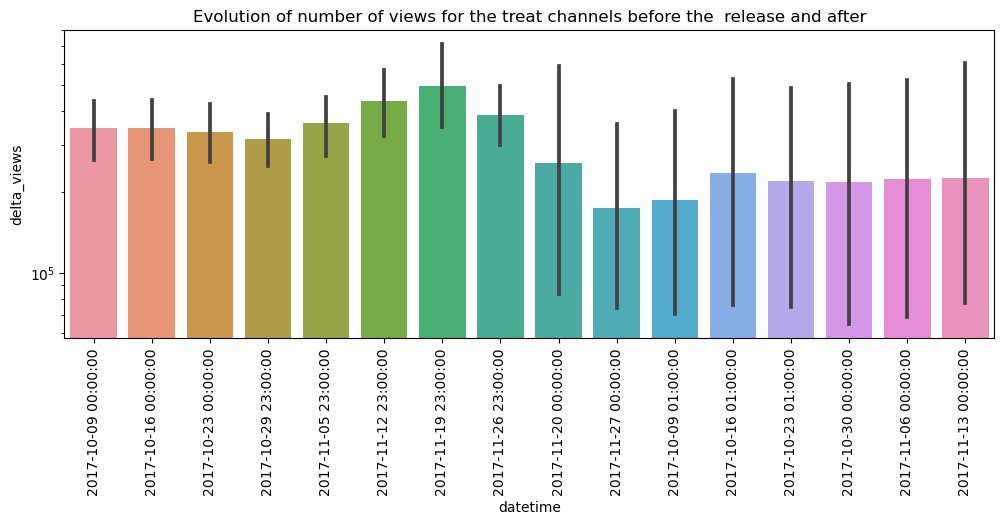

ValueError: min() arg is an empty sequence

<Figure size 1200x400 with 0 Axes>

In [31]:
#We compare (histograms and colors) the number of views before the release and its evolution till 1 month after thisplotting the evolution of the number of views for the treat channels
# plot the most commonly used words in tags
plt.figure(figsize=(12,4))
sns.barplot(x = df_treat['datetime'], y = df_treat['delta_views'])
plt.xticks(rotation=90)
plt.title('Evolution of number of views for the treat channels before the  release and after')
plt.yscale('log')
plt.show()

plt.figure(figsize=(12,4))
sns.barplot(x = df_control['datetime'], y = df_control['delta_views'])
plt.xticks(rotation=90)
plt.title('Evolution of number of views for the control channels before the release and after')
plt.yscale('log')
plt.show()



#plt.plot(df_treat['datetime'], df_treat['delta_views'], color='#0C7BDC')
#plt.xlabel('Date')
#plt.ylabel('Number of views')
#plt.title('Evolution of number of views of the channel before the  release and after')
#plt.plot(df_control['datetime'], df_control['delta_views'], color ='#DC770C')

#Show the plot
#plt.show()


In [32]:
#fig, axs = plt.subplots(1, figsize=(20, 20))
#axs[0].bar(df_treat['datetime'], df_treat['delta_views'], color='#0C7BDC')
#axs[0].set_title("View Count Over Time")
    #axs[0].axvline(x=, color="red", linestyle="--")
#fig.suptitle("Scores Over Time for {product_name}".format('iphone x"'), fontsize=30)
#plt.show()

### conclusion from the plots

### Observational analysis (lab5)

### Plots after the analysis